## PROJECT THREE - PART THREE

### ASSEMBLY OF KETO AND WINE DATAFRAMES AND EDA

**OVERVIEW**

**PREPARATION**

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import nltk
import json
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import regex as re

from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix

In [2]:
keto= pd.read_csv('keto_push_clean.csv')
keto.drop(columns = ['Unnamed: 0'],inplace=True)

In [3]:
wine= pd.read_csv('wine_push_clean.csv')
wine.drop(columns = ['Unnamed: 0'],inplace=True)

**BALANCE THE DATAFRAMES**

In [4]:
keto.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,It's been a hot minute,I keep getting off track when it comes to keto...,keto,1580160840,bbwsoontobebw,5,1,True,2020-01-27
1,Type 1 Diabetes on Keto,"Hello, I’m beginning my second month of keto. ...",keto,1580160905,iWantNotToWant,10,1,True,2020-01-27
2,"Week 3,5 and intense cravings for bread and rice","Week 3,5 and I am having intense cravings for ...",keto,1580161118,littleboo2theboo,10,1,True,2020-01-27
3,12-Week Challenge at the gym and looking for t...,"Hi guys,\n\nI am looking for some advice. I di...",keto,1580161503,chow_shepard,4,1,True,2020-01-27
4,"Does never going ""Full Keto"" hurt my health?",Hello!\n\nI'm a active highschooler who avoids...,keto,1580161639,OrganizingChaosBrb,3,1,True,2020-01-27


In [5]:
wine.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Looking for a summer job,"Hi,\n\nI'm a 23 year-old man from the Netherla...",wine,1580165102,Loirettoux,3,1,True,2020-01-27
1,California whites,"Whenever I try a Californian wine, it's always...",wine,1580170191,RaphGiroux,8,1,True,2020-01-27
2,Wine suggestions while in France (Provence),Will be traveling to France and spending most ...,wine,1580177480,irishmuse,4,1,True,2020-01-27
3,Show me the Munny Hunny | Wine Industry Report...,"If you are in the wine industry, congratulatio...",wine,1580177690,cudaeducation,0,1,True,2020-01-27
4,Going to Burgundy in May,"Hi, I'll be going to Burgundy during May and w...",wine,1580182920,GaanZi,5,1,True,2020-01-27


In [6]:
keto.shape

(7894, 9)

In [7]:
wine.shape

(2882, 9)

In [8]:
remove_n = 5012
drop_indices = np.random.choice(keto.index, remove_n, replace=False)
keto_subset = keto.drop(drop_indices)

In [9]:
keto_subset.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
8,Alcoholism and keto,Please be kind. I have a problem with alcohol....,keto,1580164064,Hayleyhall86,51,1,True,2020-01-27
18,"4 days in, and i forgot how important electrol...",Got back on the wagon 4 days ago after ditchin...,keto,1580172079,ThatGuyWithaReason,9,1,True,2020-01-27
20,My Rebel Ice Cream is missing it's seal... Is ...,So I just got home with some Rebel Ice Cream a...,keto,1580173824,Little_g_Design,18,1,True,2020-01-27
21,How soon do you feel ketosis? And what does it...,I’m actually not doing a keto diet consciously...,keto,1580174194,silversteinrich,11,1,True,2020-01-27
23,Reached goal weight,I’ve been going keto for about about two month...,keto,1580175156,sushiqueen99,4,1,True,2020-01-27


**COMBINE THE DATAFRAMES AND FOCUS FEATURES**

In [10]:
keto_wine = pd.concat([keto_subset,wine])

In [11]:
keto_wine.drop(columns=['created_utc','author','num_comments','score','is_self','timestamp'], inplace=True)

In [12]:
keto_wine['subreddit']=keto_wine['subreddit'].map({'keto':0,'wine':1})

In [13]:
keto_wine.reset_index(drop=True)

,title,selftext,subreddit
0,Alcoholism and keto,Please be kind. I have a problem with alcohol....,0
1,"4 days in, and i forgot how important electrol...",Got back on the wagon 4 days ago after ditchin...,0
2,My Rebel Ice Cream is missing it's seal... Is ...,So I just got home with some Rebel Ice Cream a...,0
3,How soon do you feel ketosis? And what does it...,I’m actually not doing a keto diet consciously...,0
4,Reached goal weight,I’ve been going keto for about about two month...,0
...,...,...,...
5759,Best place to ask quick questions about wine?,Is there a separate sub where newbies can ask ...,1
5760,Pairing wine with oral sex (NSFW),**this is a serious post. I’m not trolling**\n...,1
5761,"(Not a wine expert) Found an old wine, can som...",Hey!\nI dig out an old bottle my mom got a goo...,1
5762,Basic Wine Cellar Question,Good afternoon Reditors.\n\nI am having some f...,1


**COMBINE TITLE AND SELFTEXT COLUMNS TO PREP FOR VECTORIZER** 

In [14]:
keto_wine['titleself']=keto_wine['title']+' '+keto_wine['selftext']
keto_wine

,title,selftext,subreddit,titleself
8,Alcoholism and keto,Please be kind. I have a problem with alcohol....,0,Alcoholism and keto Please be kind. I have a p...
18,"4 days in, and i forgot how important electrol...",Got back on the wagon 4 days ago after ditchin...,0,"4 days in, and i forgot how important electrol..."
20,My Rebel Ice Cream is missing it's seal... Is ...,So I just got home with some Rebel Ice Cream a...,0,My Rebel Ice Cream is missing it's seal... Is ...
21,How soon do you feel ketosis? And what does it...,I’m actually not doing a keto diet consciously...,0,How soon do you feel ketosis? And what does it...
23,Reached goal weight,I’ve been going keto for about about two month...,0,Reached goal weight I’ve been going keto for a...
...,...,...,...,...
2877,Best place to ask quick questions about wine?,Is there a separate sub where newbies can ask ...,1,Best place to ask quick questions about wine? ...
2878,Pairing wine with oral sex (NSFW),**this is a serious post. I’m not trolling**\n...,1,Pairing wine with oral sex (NSFW) **this is a ...
2879,"(Not a wine expert) Found an old wine, can som...",Hey!\nI dig out an old bottle my mom got a goo...,1,"(Not a wine expert) Found an old wine, can som..."
2880,Basic Wine Cellar Question,Good afternoon Reditors.\n\nI am having some f...,1,Basic Wine Cellar Question Good afternoon Redi...


In [15]:
X=keto_wine['titleself']
y=keto_wine.subreddit

In [16]:
# Assess y
y.value_counts()

1    2882
0    2882
Name: subreddit, dtype: int64

In [17]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                   random_state=42)

**APPLY VECTORIZER**

In [51]:
cvec=CountVectorizer(stop_words='english',max_features=1000,ngram_range=(1,2))

In [52]:
cvec.fit(X_train)
# cvec.fit(keto_wine['titleself'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=1000, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [53]:
print(cvec.vocabulary_)

{'keto': 472, '19': 10, 'years': 992, 'ago': 50, 'away': 77, 'just': 466, 'left': 503, 'days': 217, 'day': 216, 'haven': 391, 'like': 512, 'particular': 653, 'tips': 887, 'help': 402, 'doesn': 240, 'want': 941, 'diet': 231, 'point': 673, 'probably': 691, 'protein': 699, 'intake': 450, 'actually': 41, 'did': 229, 'yesterday': 995, 'minutes': 580, 'price': 690, 'today': 892, 'weight': 956, 'shot': 784, 'lack': 493, 'normally': 615, 'currently': 209, 'goal': 356, 'calorie': 130, 'years ago': 993, 'keto diet': 473, 'napa': 596, 'winery': 971, 'birthday': 96, 'trip': 906, 'november': 620, 'visiting': 938, 'recommendations': 724, 'wineries': 970, 'visit': 937, 'time': 885, 'excited': 285, 'finally': 316, 'best': 92, 'wine': 966, 'use': 918, 'job': 462, 'thing': 878, 'happened': 386, 'shopping': 781, 'felt': 311, 'heart': 399, 'came': 133, 'got': 366, 'super': 851, 'hot': 421, '10': 0, 'called': 129, 'talk': 861, 'perfect': 659, 'said': 752, 'hit': 412, 'went': 960, 'thanksgiving': 877, 'coup

In [54]:
X_train_cvec = cvec.transform(X_train)

In [55]:
X_test_cvec = cvec.transform(X_test)

In [56]:
keto_wine_train = pd.DataFrame(X_train_cvec.toarray(),
                        columns=cvec.get_feature_names())
keto_wine_train

,10,100,11,12,13,14,15,150,16,18,...,year,year old,years,years ago,yes,yesterday,yogurt,young,youtube,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,2,1,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3856,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3857,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3858,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3859,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
keto_wine_test = pd.DataFrame(X_test_cvec.toarray(),
                        columns=cvec.get_feature_names())
keto_wine_test

,10,100,11,12,13,14,15,150,16,18,...,year,year old,years,years ago,yes,yesterday,yogurt,young,youtube,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1898,0,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1899,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1900,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1901,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [58]:
lr=LogisticRegression()

In [59]:
lr.fit(X_train_cvec,y_train)

C:\Users\tonyb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
lr.coef_

array([[ 1.41000799e-01,  1.75022819e-02, -2.58650689e-01,
        -5.80227757e-02,  3.49049544e-02,  1.23614693e-01,
         2.70058494e-01,  2.50153109e-02, -9.77234108e-02,
        -5.32631146e-02,  5.26813065e-02, -9.07362935e-02,
         1.01980205e-01,  1.54738755e-01,  4.69123333e-02,
         1.54076624e-01,  1.19271302e-01,  2.18710357e-01,
         2.95954188e-01,  6.14187361e-01,  3.32755187e-01,
         2.07372479e-01,  4.34177604e-02, -4.18468463e-01,
        -7.59714906e-02,  6.67161783e-02,  6.16331907e-02,
        -2.01292265e-01,  1.86344444e-02, -3.95185554e-02,
         2.96294773e-01, -6.42912506e-03, -1.88141859e-01,
         9.16259018e-03, -1.98217586e-01,  2.11816392e-01,
        -2.20616712e-01,  1.64906414e-01,  6.73010658e-02,
         9.14303166e-02, -1.67599058e-01,  2.92556304e-02,
         5.71083635e-02, -6.53954986e-02,  2.17398953e-01,
         7.27998285e-02,  1.91334237e-01,  3.72563524e-01,
         8.13871734e-02,  1.07605648e-01,  1.81404170e-0

In [61]:
np.exp(lr.coef_)

array([[ 1.15142557,  1.01765634,  0.77209268,  0.94362846,  1.03552128,
         1.13157978,  1.31004108,  1.02533082,  0.90689971,  0.94813051,
         1.05409366,  0.91325851,  1.10736155,  1.16735296,  1.04803013,
         1.16658027,  1.12667555,  1.24447077,  1.34440857,  1.84815411,
         1.39480579,  1.2304408 ,  1.0443741 ,  0.65805388,  0.92684263,
         1.06899203,  1.06357214,  0.81767342,  1.01880915,  0.96125212,
         1.34486653,  0.9935915 ,  0.82849717,  1.0092047 ,  0.82019137,
         1.23592094,  0.80202403,  1.17928275,  1.06961745,  1.09574042,
         0.84569284,  1.02968778,  1.05877054,  0.93669693,  1.24283984,
         1.07551523,  1.2108641 ,  1.45145068,  1.08479082,  1.1136085 ,
         1.19889964,  0.87801839,  0.66740066,  1.00804581,  0.99576083,
         1.578764  ,  1.33848903,  1.05194509,  0.89968607,  0.96017268,
         1.11809406,  1.12775559,  0.8054696 ,  1.38179009,  1.7575892 ,
         0.87960878,  1.36079573,  1.02791177,  0.7

In [62]:
preds = lr.predict(X_test_cvec)

In [63]:
preds

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [64]:
lr.score(X_test_cvec,y_test)

0.9879138202837625

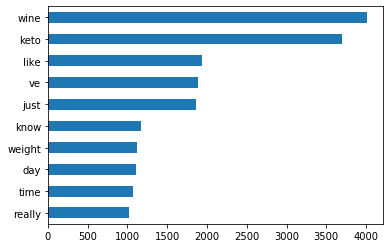

In [67]:
keto_wine_train.sum().sort_values().tail(10).plot(kind = 'barh')